# Summer project 

Note that you should have CAMB installed, which can be done by running `pip install camb`. For more information, visit https://camb.info/.

The theory is heavily inspired in the articles contained on the folder ''Papers/''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from astropy import constants as const
import scipy.integrate as integrate

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders. Delete these two lines for pip/conda install.
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
# make sure the version and path is what you expect

Using CAMB 1.3.6 installed at /home/vpedre/anaconda3/lib/python3.9/site-packages/camb


## Getting familiar with CAMB

### Basic functions

In [2]:
pars = model.CAMBparams()  # Set of parameters created

# Some parameters were set as showed in the demo
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.022
 omch2 = 0.122
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.5
 TCMB = 2.7255
 YHe = 0.24524332588411976
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 

In [3]:
camb.get_age(pars)  # age of the universe for given set of parameters

13.74073863845039

In [4]:
results = camb.get_results(pars)

# neutino is for massles and nu for massive neutrinos
var = ['K', 'cdm', 'baryon', 'photon', 'neutrino' , 'nu', 'de']
Om_tot = 0

for v in var:
    Om_tot += results.get_Omega(v)

Om_tot

1.0

## Cosmological parameters from Planck

From [Planck Collaboration (2018)](https://arxiv.org/pdf/1807.06209.pdf) Table 1, ''Combined'' column.

Something worth remembering $\sum_i^n \Omega_i(z) + \Omega_K(z) = 1$

In [5]:
pars = model.CAMBparams()  # Set of parameters created

pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')
pars.set_cosmology(H0=67.4, ombh2=0.02233, omch2=0.1198, omk=0, tau=0.054)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02233
 omch2 = 0.1198
 omk = 0.0
 omnuh2 = 0.0006451383989381787
 H0 = 67.4
 TCMB = 2.7255
 YHe = 0.24538288182613635
 num_nu_massless = 2.030666666666667
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0153333333333332]
 nu_mass_fractions = [1.0]
 nu_mass_numbers = [1]
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun

In [6]:
results = camb.get_results(pars)

omde = results.get_Omega('de')
omk = pars.omk
omm = 1 - omde - omk

## Background Quantities

In the context of GR, cosmic acceleration requires a fluid, dubbed **Dark Energy** (DE), with an equation of state $w_{DE} < -1/3$. The standard model of csomology, commonly refered to as the $\Lambda CDM$ model, assumes that this phenomenon is due to the presence of a cosmological constant $\Lambda$ described by a constant equation state $w_{\Lambda} = -1$, which corresponds to a time-independent energy density. This has some problems (*cosmological constant problem* and *coincidence problem*), so a more general scenario for the component responsible for cosmic acceleration postulates a dynamical DE, with a dependent equation of state parameter $w_{DE}(z)$.
$$w_{DE}(z) = w_0 + w_a\frac{z}{1+z}$$
Where $w_0$ is  the present value of the equation of state and $w_a$ is a measure of its variation. The evolution of the DE density obeys
$$\rho_{DE} (z) = \rho_{DE,0} (1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] $$

Then, we can get
$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{DE,0}(1+z)^{3(1+w_0+w_a)}exp\left[-3w_a\frac{z}{1+z}\right] + \Omega_{K,0}(1+z)^2
}$$
With the current DE density $\Omega_{DE,0}$ satisfying the relation $\Omega_{DE,0} = 1 - \Omega_{m,0} - \Omega_{K, 0}$. The $\Lambda CDM$ model can be recovered by setting $w_0=-1$ and $w_a=0$, in which case

$$E(z) = \sqrt{
    \Omega_{m,0}(1+z)^3 + \Omega_{\Lambda,0} + \Omega_{K,0}(1+z)^2
}$$

In [7]:
def E(z, Omm=omm, Omde=omde, OmK=omk, w_0=pars.DarkEnergy.w, w_a=pars.DarkEnergy.wa):
    bar = Omm * (1 + z) ** 3
    de = Omde * (1 + z) ** (3 * (1 + w_0 + w_a)) * np.exp(-3 * w_a * z / (1 + z))
    cur = OmK * (1 + z) ** 2
    return np.sqrt(bar + de + cur)

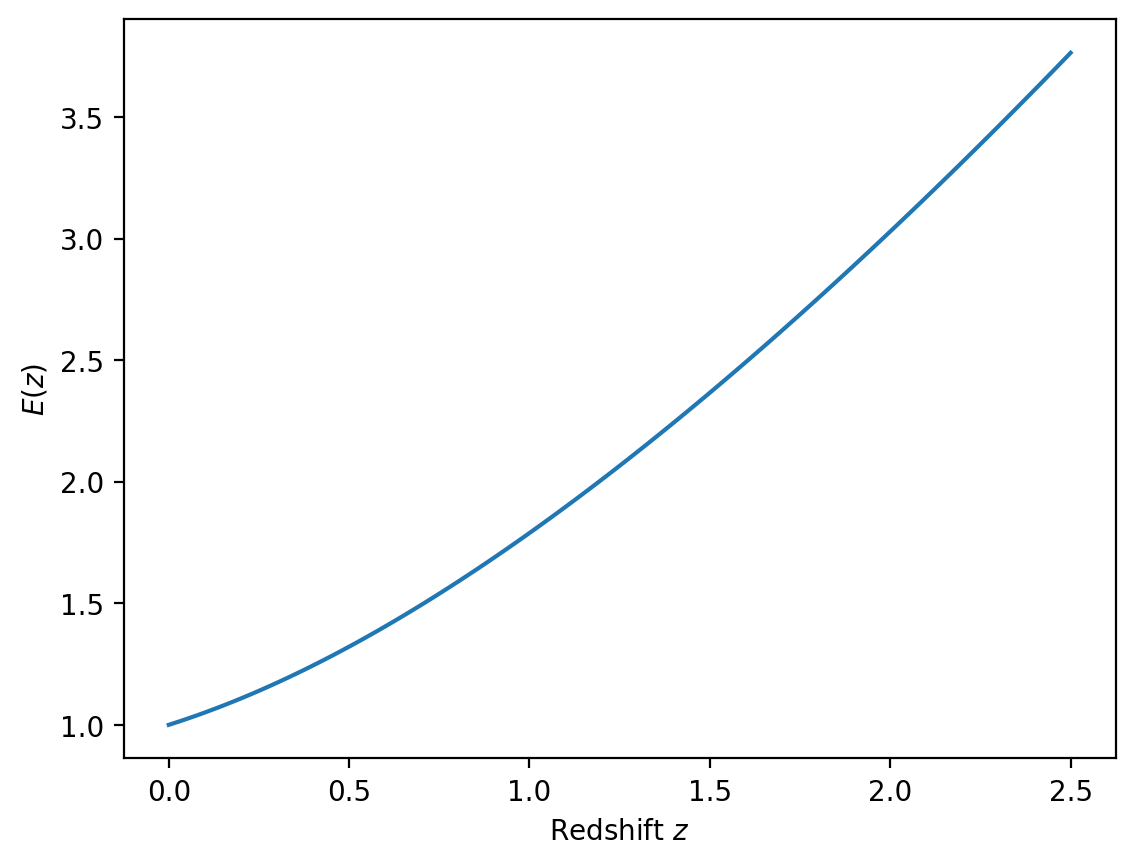

In [8]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()

ax.plot(z_to_plot, E(z_to_plot))
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$E(z)$');
# ax.set_title('');

## Distance measurements

The comoving distance to an object at redshift $z$ can be computed as
$$r(z)  \frac{c}{H_0} \int _0^z \frac{dz}{E(z)}$$
This quantity is not a direct observable, but it is closely related to other distance definitions that are directly linked with cosmological observations. A relevant distance is the **angular diameter disantance** (at least for our forecasts), whose definitiion is based on the relation between the apparent angular size of an object and its true physical size in Euclidean space, which is relate to the comoving distance by
$$D_A(z) = \begin{cases}
(1 + z)^{-1} \frac{c}{H_0} \frac{1}{\sqrt{|\Omega_{K,0}|}} sin\left[\sqrt{|\Omega_{K,0}|} \frac{H_0}{c}r(z)\right]& \text{if}\, \, \Omega_{K,0} < 0 \\
(1 + z)^{-1} r(z) & \text{if}\, \, \Omega_{K,0} = 0 \\
(1 + z)^{-1} \frac{c}{H_0} \frac{1}{\sqrt{\Omega_{K,0}}} sinh\left[\sqrt{\Omega_{K,0}} \frac{H_0}{c}r(z)\right]& \text{if}\, \, \Omega_{K,0} < 0 \\
\end{cases}$$

and this angular diameter distance is related to the transverse comoving distance by $D_A = D_M / (1+z)$

In [9]:
def r(z):
    """Comoving Distance as a function of the redshift
    Quad integration from scipy is used.
    ===================================================
    Input: redshift z
    Output: comoving distance r
    """
    def integrand(u):
        return 1/E(u)
    integral = integrate.quad(integrand, 0, z)[0]
    return const.c.value / pars.H0 * integral

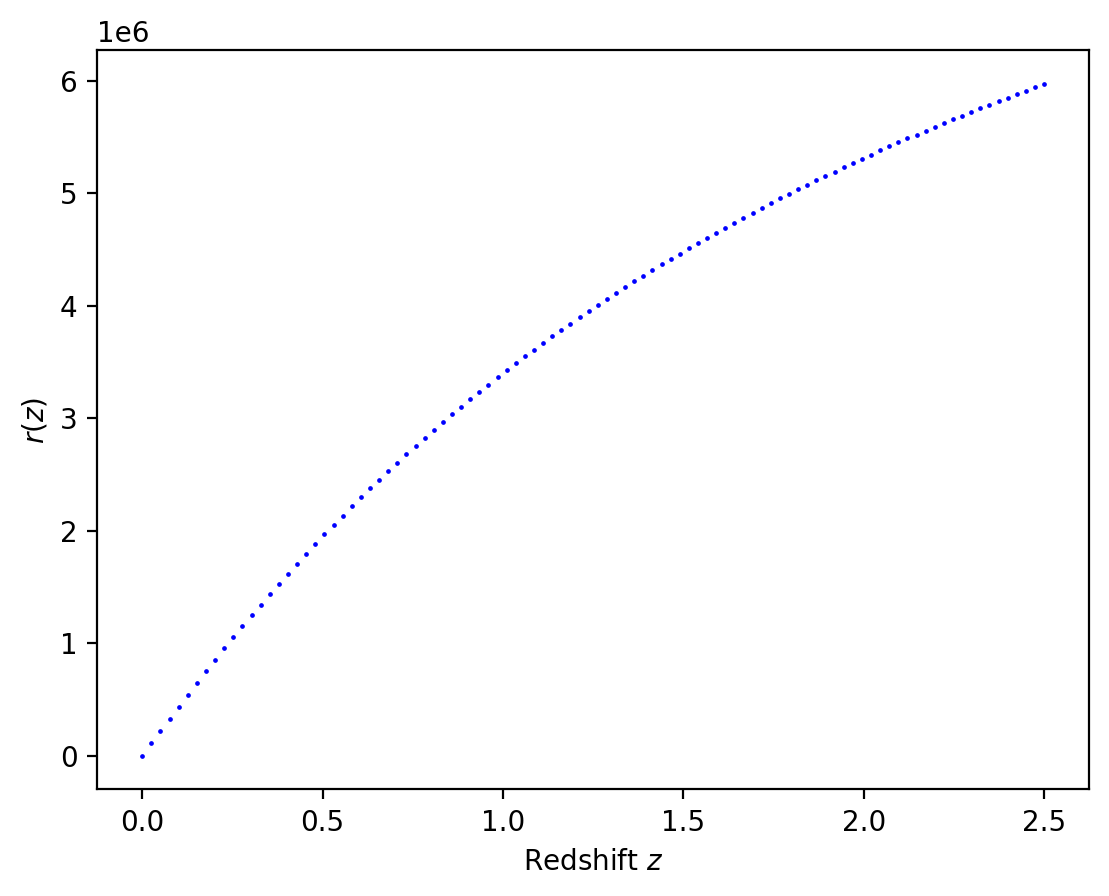

In [10]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()
for z in z_to_plot:
    ax.scatter(z, r(z), c='b', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$r(z)$');
# ax.set_title('');

In [11]:
def D_A(z, Omk=omk):
    """Angular diameter distance as a function of the redshift.
    Note that there are different definitions for different
    space-time curvatures.
    ===================================================
    Inputs: redshift z; curvature density Omk, default given by camb (optional)
    Outputs: angular diameter distance D_A
    """
    if Omk == 0:
        return r(z) / (1 + z)
    
    arg = np.sqrt(np.abs(Omk)) * pars.H0 / const.c.value * r(z)
    prop_const = const.c.value / pars.H0 / np.sqrt(np.abs(Omk))
    
    if Omk < 0:
        return prop_const / (1 + z) * np.sin(arg)

    else:
        return prop_const / (1 + z) * np.sinh(arg)


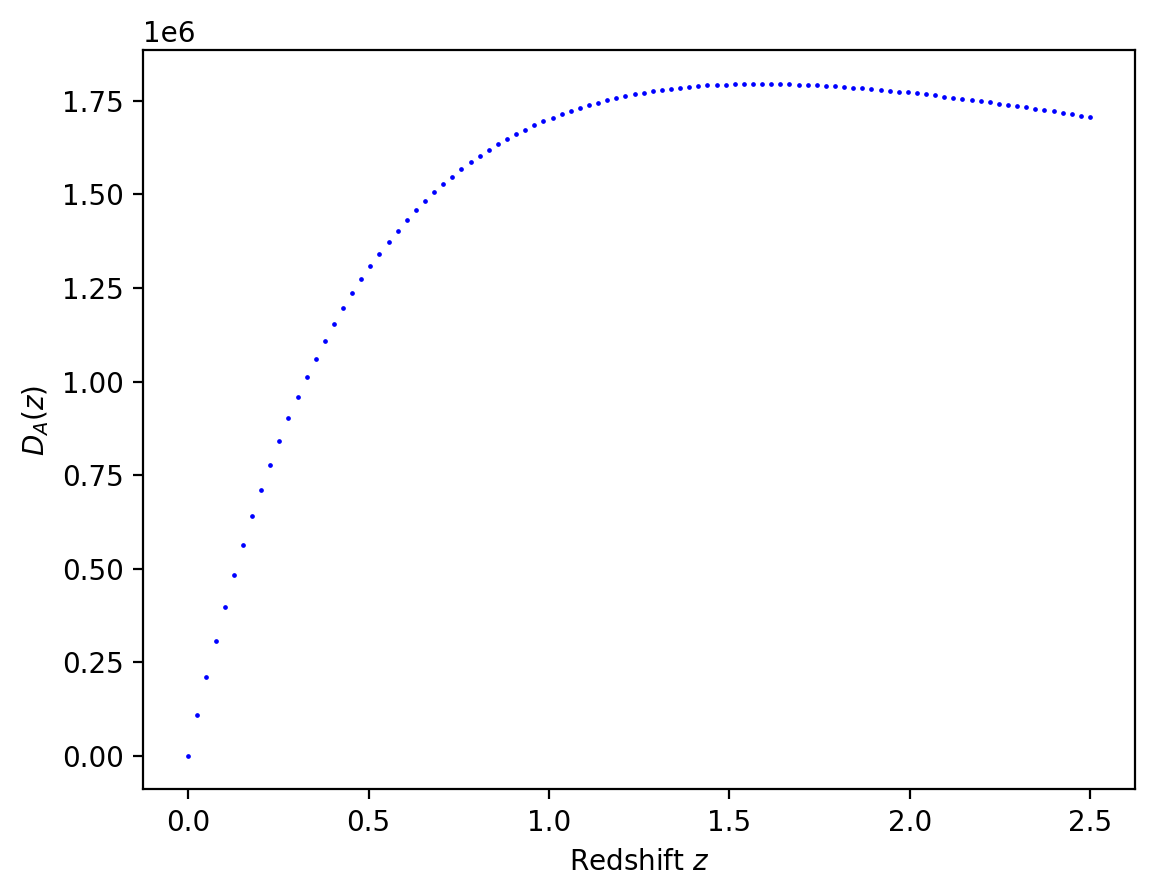

In [12]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()
for z in z_to_plot:
    ax.scatter(z, D_A(z), c='b', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$D_A(z)$');
# ax.set_title('');

## Linear perturbations

The evolution of the quantum fluctuations from the primordial Universe, for non-relativistic matter on sub-horizon scales can be described by ideal fluid equations. Density fluctuations for a given component $i$ are characterised by the density constrast

$$\delta_i(\mathbf{x},z) \equiv \rho_i(\mathbf{x},z) / \bar{\rho}_i(z) - 1$$

which quantifies the deviations of the density field $\rho_i(\mathbf{x},z)$ around the mean spatial density \bar{\rho}_i(z) over space, where $\mathbf{x}$ is a three dimensional comoving coordinate at a redshift $z$. Working in Fourier space

$$\delta_i(\mathbf{x},z) = \int \frac{d³k}{(2\pi)³ }\tilde{\delta}_i(\mathbf{k}, z)exp(-i\mathbf{k} \cdot \mathbf{x})$$

The powe spectrum, dimensionless primordial power spectrum of the curvature perturbation generated by inflation, and the transfer function can be defined.

The growth of density fluctuations obeys a second-order differential equation. At early enough times, when the fluctuations are small the field equations can be linearised. During matter domination, considering matter as a pressurless ideal fluid, the equation for the evolution of the density contrast becomes.

$$\ddot{\delta}_m (\mathbf{k},z) + 2H\dot{\delta}_m (\mathbf{k},z) - \frac{3H_0²\Omega_{m,0}}{2a³}\delta_m(\mathbf{k},z) =0$$
In the $\Lambda CDM$ scenario, with no massive neutrinos and in terms of the redshift

$$\delta''_m (\mathbf{k},z) + \left[\frac{H'(z)}{H(z)} - \frac{1}{1+z} \right]\delta'_m (\mathbf{k},z) - \frac{3}{2}\frac{\Omega_m(z)}{(1+z)²}\delta_m(\mathbf{k},z)=0$$

where dark energy perturbations were neglected and $\Omega_m(z) = \Omega_{m,0}(1+z)² / E²(z)$
 

## Weak lensing observable

We refer to *weak lensing* as the physical phenomenom and *cosmic shear* as the observable summary statistic that uses weak lensing to extract cosmological parameters.

The large-sacale cosmic structure deflects the path of photons from distant galaxies, which induces distortions in the images of these galaxies. *Convergence* is a change in the observed size of a galaxy and *shear* is a change in the observed third flattening or third eccentricity (known as ellipticity or polarisation). The shear field caused by large-scale structure has zero mean because we assume isotropy and homogeneity of the Universe, but tis two-point correlation function and its power spectrum contain cosmological information that probes both the background evolution of the Universe and the growth of cosmic structure. This two point statistics are known as 'cosmic shear'.

In order to exploit the cosmic shear for cosmological parameter inference, the real/configuration space measurementof the two-point statistic, as a function of angular separation on the celestial sphere, is known as the *cosmic shear correlation function*. While the angular speherical-harmonic measurement of the two-point statistic is kown as the *cosmic shear power spectrum*. Both these statistics can be computed in a series of redshift bins, which is known as *tomography* and is required in order to achieve high-precision dark energy measurements. We will be focused on the latter statistic.

We consider five main quatities that must be modeled in order to recover the observable cosmic shear power spectrum.

1. **The cosmic shear power spectrum**. Is the change in the ellipticity of the image of a background galaxy, caused by the lensing effect of large-scale structure along the los. For an individual galaxy we express this, to linear order, as $$\epsilon = \gamma + \epsilon^I$$ where $\gamma$ is the cosmological shear and $\epsilon^I$ is the intrinsic ellipticity. This ellipticity is a spin-2 quantity with zero mean over a large survey area and a a non-zero two-point correlation function or power spectrum, encoding information on the expansion history of the Universe and the matter power spectrum. The spherical harmonic transform of the two-point correlation function is the angular power spectrum. Since the full computation of the csomic shear power spectrum is laborious, the Limber approximation is adopted, which allows us to write the observable as $$C_{ij}^{\gamma\gamma}(l)\simeq \frac{c}{H_0}\int dz\frac{W_i^\gamma(z)W_j^\gamma(z)}{E(z)r²(z)}P_{\delta\delta}\left[\frac{l + 1/2}{r(z)},z\right]$$ where $i$ and $j$ identify pairs of redshift bins, $E(z)$ was defined previously, $r(z)$ is the comoving distance, $P_{\delta\delta}(k,z)$ is the matter power spectrum evaluated at $k=k_l(z)\equiv(l+1/2)/r(z)$ (Limber approximation), and the weight functions $W^\gamma(z)$ are defined as $$W_i^\gamma(z) = \frac{3}{2}\left(\frac{H_0}{c}\right)²\Omega_{m,0}(1+z)r(z)\int_z^{z_{max}}dz'n_i(z')\left[1-\frac{\tilde{r}(z)}{\tilde{r}(z')}\right] = \frac{3}{2}\left(\frac{H_0}{c}\right)²\Omega_{m,0}(1+z)r(z)\tilde{W}_i(z)$$ where $\tilde{W}_i(z)$ is the **window function**

2. **The intrinsic alignment power spectrum**

In [13]:
z_bins = [(i*0.025, (i+1)*0.025) for i in range(100)]

# How many points fall in each bin 
#[sum([(value >= low) and (value < high) for value in data]) for low, high in bins]

In [45]:
def pdf(zp, z, cb=1.0, zb=0.0, sigb=0.05, co=1.0, zo=0.1, sigo=0.05, fout=0.1):
    """Probability distribution function.
    Describes the probability that a galaxy with
    redshift z has a measured redshift zp.
    ===================================================
    Inputs: measured reshift zp; galaxy redshift z;
    parameters to describe  the photometric redshift
    distribution of sources (optionals), defaults:
    cb=1, zb=0, sigb=0.05, co=1, zo=1, sigo=0.05, fout=0.1
    Output: probability that the galaxy of redshift z
    has a measured redshift zp.
    """
    exp1 = np.exp(-1 / 2 * ((z - cb * zp - zb) / sigb * (1 + z)) ** 2)
    exp2 = np.exp(-1 / 2 * ((z - co * zp - zo) / sigo * (1 + z)) ** 2)

    term1 = (1 - fout) / (np.sqrt(2 * np.pi) * sigb * (1+ z))
    term2 = fout / (np.sqrt(2 * np.pi) * sigo * (1+ z))

    return term1 * exp1 + term2 * exp2


def n(z, zm=0.9):
    """Underlying distribution of density.
    This expression is chosen in agreement with Euclid
    Red Book. Note that this does NOT take into account
    the proportional constant.
    ===================================================
    Inputs: redshift z, median redshift zp (optional,
    default is 0.9 according to Euclid Red Book)
    Output: number density at redshift z.
    """
    z0 = zm / np.sqrt(2)
    return (z / z0) ** 2 * np.exp(-(z / z0) ** (3 / 2))


def bin_number_density(i, z, zmin=0.0, zmax=2.5):
    """Number density of observed galaxies in the ith bin.
    Quad integration from scipy is used.
    ===================================================
    Inputs: bin number i, redshift z, min/max redshift 
    zmin/zmax (optional, default=0.0/2.5)
    Output: number density at redshift z in the ith bin.
    """
    ith_bin = z_bins[i]
    zi_l, zi_u = ith_bin

    def integrand1(u):
        return n(z) * pdf(u, z)    
    
    def integrand2(v, w):
        return n(w) * pdf(v, w)  

    num = integrate.quad(integrand1, zi_l, zi_u)[0]
    den = integrate.nquad(integrand2, [[zi_l, zi_u], [zmin, zmax]])[0]
    
    return num / den

def window(i, z, zmin=0.0, zmax=2.5):
    """Reduced window function as a function of redshift.
    Quad integration from scipy is used.
    ===================================================
    Inputs: bin number i, redshift z, min/max redshift 
    zmin/zmax (optional, default=0.0/2.5)
    Output: window function evaluated at z
    """
    def integrand(w):
        return bin_number_density(i, w) * (1 - r(z) / r(w))
    return integrate.quad(integrand, z, zmax)[0]

In [ ]:
z_to_plot = np.linspace(0, 2.5, 100)

fig, ax = plt.subplots()
for z in z_to_plot:
    ax.scatter(z, r(z), c='b', s=0.5)
ax.set_xlabel('Redshift $z$')
ax.set_ylabel('$r(z)$');
# ax.set_title('');

In [50]:
fig, ax = plt.subplots()

for z in z_to_plot:
    ax.plot(window(50, z))
ax.set_xlabel('Redshift $z$')
ax.set_ylabel(r'Window function $\tilde{W}_i(z)$');